# <span style="color:green"> Numerical Simulation Laboratory (NSL) </span>
## <span style="color:blue">  Numerical exercises 3</span>

### Exercise 03.1 <span style="color:red"> Plain vanilla option pricing </span>

Black-Scholes theory assumes that the time evolution of the asset price is stochastic and exhibits geometric Brownian motion (GBM) with constant risk-free interest rate $r$ and volatility $\sigma$.

Black-Scholes <span style="color:blue"> analytic solution </span> for the price at time t<T:
- European Call-option price:
$$ C\left[ S(t),t \right] = S(t) N(d_1) -K e^{-r(T-t)} N(d_2) $$
- European Put-option price:
$$ C\left[ S(t),t \right] = S(t) \left[ N(d_1)-1\right] -K e^{-r(T-t)} \left[ N(d_2)-1\right]$$

where 
$$d_1 = \frac{1}{\sigma\sqrt{T-t}}\left[ \ln \left( \frac{S(t)}{K} \right) + \left( r+\frac{\sigma^2}{2} (T-t) \right)\right]$$

where $d_2 = d_1 - \sigma\sqrt{T-t}$, and where
$$ N(x) = \int_{-\infty}^{x} dz \, e^{-\frac{z^2}{2}} = \frac{1}{2} \left[ 1+ {\rm erf} \left( \frac{x}{\sqrt{2}}\right) \right]$$
is the cumulative of Gaussian $\sim \mathcal{N}(\mu=0,\sigma^2=1)$,
and where
$${\rm erf}(x) = \frac{2}{\sqrt{\pi}}\int_{0}^{x} dz \, e^{-z^2}$$

By using the following parameters: 
- asset price at $t=0$: $S(0)=100$
- delivery time: $T=1$
- strike price: $K=100$
- risk-free interest rate: $r=0.1$
- volatility: $\sigma=0.25$

compute at time $t=0$ **via Monte Carlo** the European call-option price, $C[S(0),0]$, and put-option price, $P[S(0),0]$:

1. <span style="color:red"> By sampling **directly** the final asset price $S(T)$</span> for a $GBM(r,\sigma^2)$
2. <span style="color:red"> By sampling the discretized $GBM(r,\sigma^2)$ path of the asset price</span> 
dividing $[0,T]$ in $10^2$ time intervals: $S(0)$, $S(t_1)$, $S(t_2)$, ... up to $S(t_{100}=T=1)$

<p style="border:2px; border-style:solid; border-color:#F5F5F5; padding: 1em; background-color:#F5F5F5">
    Remember that given an asset price $S\sim GBM(\mu,\sigma^2)$, with initial value $S(0)$, then
    $$S(t) = S(0) \exp\left[ \left(\mu-\frac{1}{2}\sigma^2\right)t+\sigma W(t)\right]$$
    where $W(t)\sim\mathcal{N}(0,t)$.
    Moreover, since the increments of $W$ are independent and normally distributed, the simple recursive procedure for sampling discretized values of $S\sim GBM(\mu,\sigma^2)$ at $t_1 < t_2 < … < t_n$ is:
$$S(t_{i+1}) = S(t_i) \exp\left[ \left(\mu-\frac{1}{2}\sigma^2\right)(t_{i+1}-t_i)
    +\sigma Z_{i+1}\sqrt{t_{i+1}-t_i}\right]$$
    with $Z_i \sim \mathcal{N}(0,1)$
</p>

<span style="color:red">Make four pictures for the estimation of the European call-option prices, $C[S(0),0]$ (direct and discretized), and put-option prices, $P[S(0),0]$ (direct and discretized), with their uncertainties </span> with a large number of asset prices at time $t=T$, say $M\ge 10^4$, as a function of the number of blocks, $N$</font>. <span style="color:blue"> As usual, in computing statistical uncertainties, use data blocking.</span>

### For comparison, Black-Scholes analytic solution:

In [281]:
import numpy as np
import scipy
from scipy.special import erf
from numpy import log, exp, sqrt

# data
S0 = 100.
K = 100.
T = 1.
r = 0.1
sigma = 0.25
t=0

def N(x):
    return 0.5 * (1. + erf(x / sqrt(2.)))

def black_scholes(S0, K, T, r, sigma):
    d1 = 1./(sigma * sqrt(T)) * (log(S0 / K) + (r + (sigma**2) / 2.) * T)
    d2 = d1 - sigma * sqrt(T)
    C = S0 * N(d1) - K * exp(-r * T) * N(d2)
    P = S0 *(N(d1) - 1.) - K * exp(-r * T) * (N(d2)-1.)
    return C, P

if __name__ == "__main__":
    call_true, put_true = black_scholes(S0, K, T, r, sigma)
    print(" == BLACK-SCHOLES ==")
    print("call: ", call_true)
    print("put: ", put_true)

 == BLACK-SCHOLES ==
call:  14.975790778311286
put:  5.4595325819072364


In [275]:
import math

def error(AV,AV2,n):  # Function for statistical uncertainty estimation
    if n==0:
        return 0
    else:
        return math.sqrt((AV2[n] - AV[n]**2)/n)
    
def prog_sums(n_block, array, array_squared):
    """ Return progresive sums with statistical uncertainties evaluated with data-blocking
    Par:
    n_blocks:
        Number of blocks
    array:
        Array
    array_squared:
        Array Squared
        
    Returns:
    sum_prog, err_prog
    """
    sum_prog = np.zeros(n_block)
    su2_prog = np.zeros(n_block)
    err_prog = np.zeros(n_block)
    for i in range(n_block):
        for j in range(i+1):
            sum_prog[i] += array[j] # SUM_{j=0,i} r_j
            su2_prog[i] += array_squared[j] # SUM_{j=0,i} (r_j)^2
        sum_prog[i]/=(i+1) # Cumulative average
        su2_prog[i]/=(i+1) # Cumulative square average
        err_prog[i] = error(sum_prog,su2_prog,i) # Statistical uncertainty
    return sum_prog, err_prog

**Call/Put option directly sampling S(T):**

In [288]:
mean = r-sigma**2/2
deltaT = 1.              # T - t_0
M = 10**4
N = 100
call_opt = np.zeros(N)
call_opt2 = np.zeros(N)
put_opt = np.zeros(N)
put_opt2 = np.zeros(N)
call_direct = np.zeros(N)
call_err_direct = np.zeros(N)
put_direct = np.zeros(N)
put_err_direct = np.zeros(N)
x = np.arange(N)
x *= int(M/N)
for i in range(N):
    call = 0
    put = 0
    for j in range(int(M/N)):
        w = np.random.normal(scale=deltaT)   # W(T) ~ N(0, T)
        S_T = S0*np.exp(mean+sigma*w)        # Estraggo S_T
        call += np.exp(-r*deltaT)*np.max([0, (S_T-K)])
        put += np.exp(-r*deltaT)*np.max([0, (K-S_T)])
    call_opt[i] = call/(M/N)                 # Call option media in un blocco 
    call_opt2[i] = call_opt[i]**2            # '' al quadrato
    put_opt[i] = put/(M/N)                   # Put option media in un blocco
    put_opt2[i] = put_opt[i]**2              # '' al quadrato

# Somma progressiva & stima dell'errore

call_direct, call_err_direct = prog_sums(N, call_opt, call_opt2)
put_direct, put_err_direct = prog_sums(N, put_opt, put_opt2)

**Call/Put option from discretized path of S(T):**

In [289]:
mean = r-sigma**2/2
deltaT = 1.          # T - t_0
deltat = 0.01        # t_(i+1) - t_i
M = 10**4
N = 100
call_opt = np.zeros(N)
call_opt2 = np.zeros(N)
put_opt = np.zeros(N)
put_opt2 = np.zeros(N)
call_path = np.zeros(N)
call_err_path = np.zeros(N)
put_path = np.zeros(N)
put_err_path = np.zeros(N)
for i in range(N):
    call = 0
    put = 0
    for j in range(int(M/N)):
        s_t = np.zeros(100)
        for k in range(100):                # Ciclo per evolvere S(t) da S(0) a S(T)
            if k == 0:
                s_t[k] = 100
            else:
                z = np.random.normal()      # Estraggo Z ~ N(0, 1)
                s_t[k] = s_t[k-1]*np.exp((r-sigma**2/2)*deltat+sigma*z*np.sqrt(deltat))   # Calcolo S(t_(i+1))
        S_T = s_t[-1]                       # S_T è S(t_100), ultimo elemento dell'array
        call += np.exp(-r*deltaT)*np.max([0, (S_T-K)])
        put += np.exp(-r*T)*np.max([0, (K-S_T)])
    call_opt[i] = call/(M/N)                # Call option media in un blocco
    call_opt2[i] = call_opt[i]**2           # '' al quadrato
    put_opt[i] = put/(M/N)                  # Put option media in un blocco
    put_opt2[i] = put_opt[i]**2             # '' al quadrato
    
# Somma progressiva & stima dell'errore

call_path, call_err_path = prog_sums(N, call_opt, call_opt2)
put_path, put_err_path = prog_sums(N, put_opt, put_opt2)

**Plots:** 

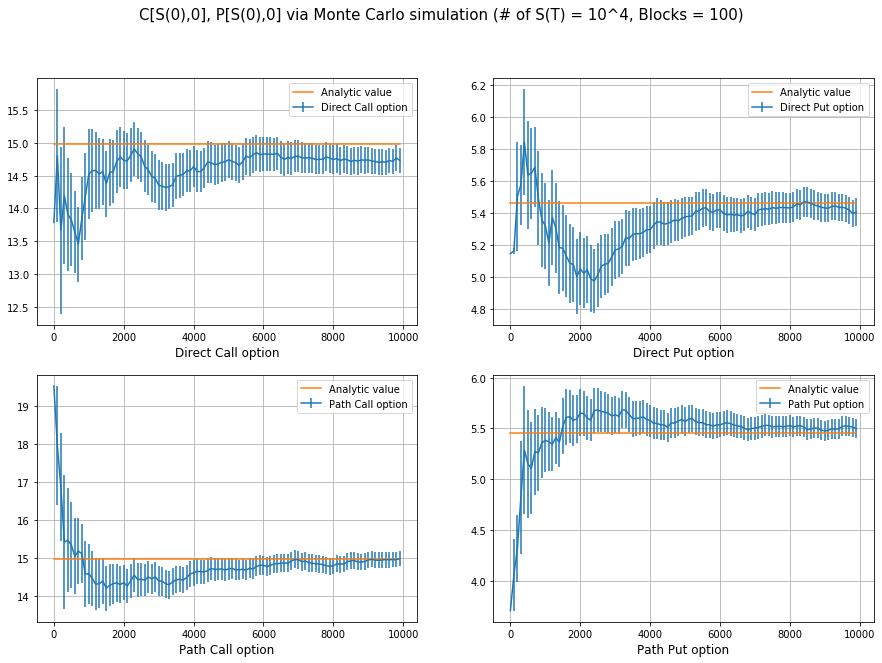

In [313]:
x = np.arange(N)
x *= int(M/N)

xlabels = ['Direct Call option', 'Direct Put option', 'Path Call option', 'Path Put option']
sets = [call_direct, put_direct, call_path, put_path]
sets_err = [call_err_direct, put_err_direct, call_err_path, put_err_path]
analytic = [call_true, put_true, call_true, put_true]

fig = plt.figure(figsize=(15,10))
fig.suptitle('C[S(0),0], P[S(0),0] via Monte Carlo simulation (# of S(T) = 10^4, Blocks = 100)', fontsize=15)
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.errorbar(x, sets[i], yerr=sets_err[i], label=xlabels[i])
    plt.plot(x, np.ones(N)*analytic[i], label='Analytic value')
    plt.xlabel(xlabels[i], fontsize=12)
    plt.grid(True)
    plt.legend()
    